In [ ]:
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train = pd.read_csv('drive/MyDrive/project3/no1_train.csv', parse_dates=['start_time'])
val = pd.read_csv('drive/MyDrive/project3/no1_validation.csv', parse_dates=['start_time'])

# **Data analysis**

In [ ]:
#Training set
train = train[['start_time','hydro', 'micro', 'thermal', 'wind', 'river', 'total', 'sys_reg', 'flow', 'y']]
train.describe()

In [ ]:
# Validation set
val = val[['start_time','hydro', 'micro', 'thermal', 'wind', 'river', 'total', 'sys_reg', 'flow', 'y']]
val.describe()

In [ ]:
val["flow"] = -val["flow"]
train["flow"] = -train["flow"]

In [ ]:
import plotly.express as px
df = pd.concat([train, val])
plt.figure(figsize=(16,9))
fig = px.line(df, x=df["start_time"], y=df["y"], title='power imbalance grid for the whole dataset')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 

Output hidden; open in https://colab.research.google.com to view.

**Target distribution**

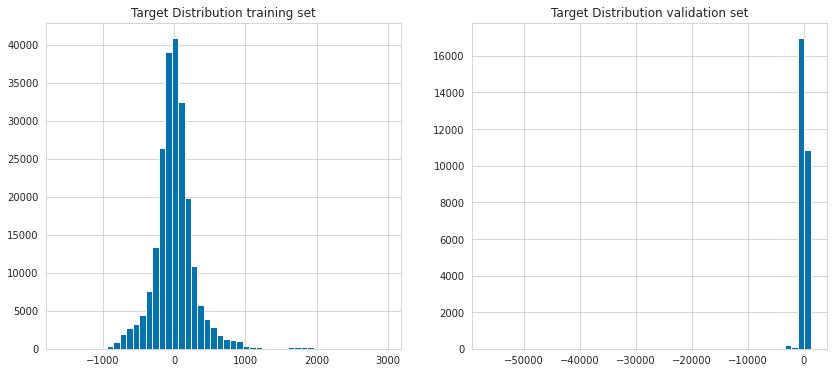

In [ ]:
from scipy import stats
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
train['y'].hist(bins=50)
plt.title('Target Distribution training set')
plt.subplot(1,2,2)
plt.title('Target Distribution validation set')
val['y'].hist(bins=50)

Check duplicated values: detect the possible duplicated values inside our dataset and delete them in the case (by comparing the shape before and then)

In [ ]:
train.duplicated()
print(train.shape)
train.drop_duplicates(inplace=True)
print(train.shape) 
val.duplicated()
print(val.shape)
val.drop_duplicates(inplace=True)
print(val.shape) 

(225088, 10)
(225088, 10)
(28136, 10)
(28136, 10)


The column river is useless because the value is always 0, so I decided to remove it

In [ ]:
del train["river"]
del val["river"]

Pandas to_datetime() method helps to convert string Date time into Python Date time object in order to extract some important features (months, days etc.)

In [ ]:
train["start_time"] = pd.to_datetime(train["start_time"])
val["start_time"] = pd.to_datetime(val["start_time"])

Check NaN values for the training and the validations set

In [ ]:
def find_NAN(df):
  droping_list_all=[]
  for j in range(0,9):
      if not df.iloc[:, j].notnull().all():
          droping_list_all.append(j)        
  if not droping_list_all:
      print("NAN values not found")
find_NAN(train)
find_NAN(val)

NAN values not found
NAN values not found


**Clamp the values of the target series to exclude noisy spikes in magnitude**
(allowed to clamp a total of 1% of the values)

In [ ]:
def percentile(df):
  Q1 = np.percentile(df["y"], 0.5)
  Q2 = np.percentile(df["y"], 99.5)
  df["y"].mask(df["y"] < Q1, Q1, inplace=True)
  df["y"].mask(df["y"] > Q2, Q2, inplace=True)
  return df
train = percentile(train)
val = percentile(val)

# **Feature engineering: date time features, lag features**

Date time features: day_of_month(1-31), hour, month, year, season, weekday etc.

In [ ]:
train['day_of_month'] = train.start_time.dt.day 
train['time_of_week'] = train.start_time.dt.day_name() #day
train['time_of_day'] = train.start_time.dt.hour #hour
train['time_of_year'] = train.start_time.dt.month #month
train['season_of_year'] = train['time_of_year'] %12 // 3 + 1
train['quarter'] = train.start_time.dt.quarter
train['year'] = train.start_time.dt.year #year
train["weekday"]=train.apply(lambda row: row["start_time"].weekday(),axis=1)
train["weekday"] = (train["weekday"] < 5).astype(int)

val['day_of_month'] = val.start_time.dt.day 
val['time_of_week'] = val.start_time.dt.day_name()
val['time_of_day'] = val.start_time.dt.hour
val['time_of_year'] = val.start_time.dt.month
val['season_of_year'] = val['time_of_year'] %12 // 3 + 1
val['year'] = val.start_time.dt.year #year
val['quarter'] = val.start_time.dt.quarter
val["weekday"]=val.apply(lambda row: row["start_time"].weekday(),axis=1)
val["weekday"] = (val["weekday"] < 5).astype(int)

In [ ]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
train['time_of_week'] = le.fit_transform(train['time_of_week'])
val['time_of_week'] = le.fit_transform(val['time_of_week'])

**Resample dataset:**
*here I decided to resample my dataset from 5 minutes to 15 minutes because I was unable to run the code with 5 minutes of resolution*

In [ ]:
train = train.set_index('start_time') 
train = train.resample('15min').mean()
val = val.set_index('start_time') 
val = val.resample('15min').mean()

**Altered forecasting**

The intention is to create a feature that represents the difference between the actual consumption (which varies continuously) and the production planned by the market (which varies in discrete steps)
Actual consumption (structural imbalance): we estimate this by a smooth interpolation of the net sum of energy fed into the current area

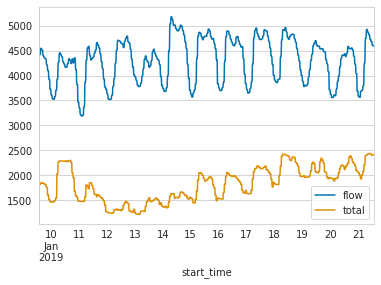

In [ ]:
train[["flow", "total"]].iloc[: 12 * 24 * 4].plot() 

In [ ]:
!pip3 install -U csaps
#csaps is a package for univariate, multivariate and nd-gridded data approximation using cubic smoothing splines.
#The package provides functionality for computing and evaluating splines and can be useful in practical engineering tasks for data approximation and smoothing.

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from csaps import csaps
#I decided to extract the sum of flow and total every 60 minutes
def altered_forecasting(df):
  df2 = df.loc[::4]
  x = df2.index
  y = df2['total'].values + df2['flow'].values
  # f = interp1d(x,y, fill_value="extrapolate",  kind=1)
  f = csaps(x, y,  smooth=0.05)
  x2 = df.index
  interpolated = f(x2)
  discrete = np.array(df['total'].values + df['flow'].values)
  df["struct_imb"] = discrete - interpolated
  df["altered"]  = df['y'] - df["struct_imb"]
  df['altered_shift'] = df['altered'].shift(1)
  return df
train = altered_forecasting(train)
val = altered_forecasting(val)

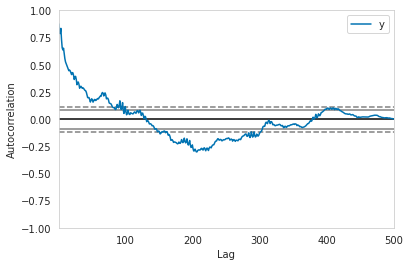

In [ ]:
pd.plotting.autocorrelation_plot(train["y"].iloc[0:500],label = "y")

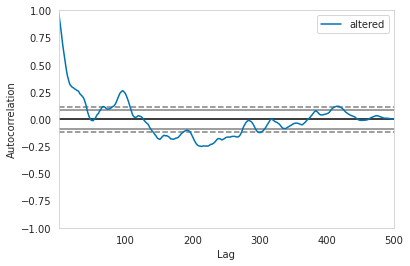

In [ ]:
#the data results in a much smoother plot
pd.plotting.autocorrelation_plot(train["altered"].iloc[0:500],label = "altered")

Lagged features: y_lagged1 (day before), y_lagged2 (2 days before) and y_lagged3 (3 days before)

In [ ]:
train['y_lagged1'] = train['y'].shift(1)
val['y_lagged1'] = val['y'].shift(1)
train['y_lagged2'] = train['y'].shift(2)
val['y_lagged2'] = val['y'].shift(2)
train['y_lagged3'] = train['y'].shift(3)
val['y_lagged3'] = val['y'].shift(3)
train = train.dropna()
val = val.dropna()
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

Other lagged features: 

*   'imb_1d_bef': y value 1 days before
*   'imb_3d_bef': y value 3 days before
*   'mean_imbalance_24': mean of 24 previous y values (6 hours before)
*   'mean_imbalance_48': mean of 24 previous y values (12 hours before)
*   'mean_imbalance_72': mean of 24 previous y values (18 hours before)





In [ ]:
train["id"] = train.index 
val["id"] = val.index 

def imbalance_d(col, df, val):
  val = 288
  y_values = df['y'].values
  if col >= val:
    return y_values[col - val]
  else: return np.nan
  
def mean_imbalance(col, df, val):
  y_values = df['y'].values
  if col >= val:
    return y_values[col - val: col].mean()
  else: return np.nan

train['imb_1d_bef'] = train["id"].apply(lambda row : imbalance_d(row, train, 96))
val['imb_1d_bef'] = val["id"].apply(lambda row : imbalance_d(row, val, 96))

train['imb_3d_bef'] = train["id"].apply(lambda row : imbalance_d(row, train, 288))
val['imb_3d_bef'] = val["id"].apply(lambda row : imbalance_d(row, val, 288))

t = 12
train['mean_imbalance_12'] = train["id"].apply(lambda row : mean_imbalance(row, train,t))
val['mean_imbalance_12'] = val["id"].apply(lambda row : mean_imbalance(row, val, t))
t = 24
train['mean_imbalance_24'] = train["id"].apply(lambda row : mean_imbalance(row, train,t))
val['mean_imbalance_24'] = val["id"].apply(lambda row : mean_imbalance(row, val, t))
t = 48
train['mean_imbalance_48'] = train["id"].apply(lambda row : mean_imbalance(row, train,t))
val['mean_imbalance_48'] = val["id"].apply(lambda row : mean_imbalance(row, val, t))
t = 72
train['mean_imbalance_72'] = train["id"].apply(lambda row : mean_imbalance(row, train,t))
val['mean_imbalance_72'] = val["id"].apply(lambda row : mean_imbalance(row, val, t))

train = train.dropna()
val = val.dropna()
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [ ]:
#check if there are NaN values
train.isna().any()

In [ ]:
#id column is useless
del train["id"]
del val["id"]

**Heatmap**: it is useful to find the correlation between target and other columns

In [ ]:
correlations = train.corr(method='pearson')
print(correlations['y'].sort_values(ascending=False).to_string())

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(data=train.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

Total is the sum of hydro, micro, river, thermal and wind so it is strictly correlated with them -> useless

In [ ]:
del train["total"]
del val["total"]

I checked also the correlation for the validation set: the year is totally white because it is constant

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(data=val.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":12})
plt.show() 

I checked the distribution of same features

In [ ]:
data_num = train[['y', 'hydro', 'micro', 'thermal', 'wind', 'flow']]
data_num.hist(figsize=(20,20))

In [ ]:
train.columns

In [ ]:
print(train.shape)
print(val.shape)

I decided to remove the datatime features because they dont improve my prediction

In [ ]:
train = train[['sys_reg','hydro', 'micro', 'thermal', 'wind', 'flow', 'struct_imb','altered_shift', 'y_lagged2', 'y_lagged3',
       'imb_3d_bef', 'mean_imbalance_12', 'mean_imbalance_24', 'mean_imbalance_48', 'y_lagged1','altered','y']]
val = val[['sys_reg','hydro', 'micro', 'thermal', 'wind', 'flow', 'struct_imb','altered_shift', 'y_lagged2', 'y_lagged3',
       'imb_3d_bef', 'mean_imbalance_12', 'mean_imbalance_24', 'mean_imbalance_48', 'y_lagged1','altered','y']]
print(train.shape) #17 features (16+1)

I saved the 2 new datasets in new_train and new_val

In [ ]:
train.to_csv('drive/MyDrive/project3/new_train_altered.csv')
val.to_csv('drive/MyDrive/project3/new_val_altered.csv')